## Applied - Question 9

This question will use College data set.

#### Import block

In [72]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('seaborn-white')


#### (a) Import and splitting dataset

In [73]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}College.csv')

# Change the ugly names!
df.columns = df.columns.str.replace(".", "_")
df.Private = df.Private.astype('category').cat.codes

# declare X, y
y = df.Apps
X = df.drop('Apps', axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# First look
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [74]:
# Declare RMSE to compare all answers
RMSE = {}

#### (b) OLS

In [75]:
# OLS and prediction
regr = skl_lm.LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

# Save to RMSE
RMSE['OLS'] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'OLS gives RMSE of {np.sqrt(mean_squared_error(y_test, y_pred))}')

OLS gives RMSE of 1193.7569213668355


#### (c) Ridge CV

With the best alpha, Ridge regression barely did any better than OLS.

In [76]:
alphas = np.arange(1, 10, 0.1)
ridge = skl_lm.RidgeCV(alphas=alphas, fit_intercept=True, cv=10).fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# Save to RMSE
RMSE['Ridge'] = np.sqrt(mean_squared_error(y_test, y_pred))

# Print out results
print(f'Ridge Regression gives RMSE of {np.sqrt(mean_squared_error(y_test, y_pred))}\n')

print(pd.Series(ridge.coef_, index=X.columns))
print('Intercept:', ridge.intercept_)

Ridge Regression gives RMSE of 1194.779676869436

Private       -327.586516
Accept           1.144047
Enroll           0.475942
Top10perc       62.855316
Top25perc      -22.661791
F_Undergrad     -0.000486
P_Undergrad      0.015898
Outstate        -0.073339
Room_Board       0.245855
Books           -0.214599
Personal        -0.088646
PhD             -5.776644
Terminal        -3.256932
S_F_Ratio        9.141881
perc_alumni    -10.909163
Expend           0.058387
Grad_Rate       11.988046
dtype: float64
Intercept: -513.5963646545333


#### (d) The Lasso CV

Again, the Lasso barely did any better than the plain old OLS model. In fact, even 
when Lasso suppresses many coefficients to 0, the RMSE is nearly identical to OLS.

In [77]:
alphas = np.arange(0.01, 1, 0.001)
lasso = skl_lm.LassoCV(alphas=alphas, fit_intercept=True, cv=10).fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Save to RMSE
RMSE['Lasso'] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'The Lasso gives RMSE of {np.sqrt(mean_squared_error(y_test, y_pred))}\n')

print(pd.Series(lasso.coef_, index=X.columns))
print('Intercept:', lasso.intercept_)

The Lasso gives RMSE of 1193.757335392484

Private       -437.168249
Accept           1.142031
Enroll           0.487829
Top10perc       62.755231
Top25perc      -22.697559
F_Undergrad     -0.006027
P_Undergrad      0.016661
Outstate        -0.067306
Room_Board       0.247246
Books           -0.206701
Personal        -0.085643
PhD             -6.257343
Terminal        -3.609639
S_F_Ratio        7.686640
perc_alumni    -10.528344
Expend           0.057793
Grad_Rate       12.031922
dtype: float64
Intercept: -414.0809487232832


#### (e) Fitting PCR

PCR falls behind in term of test accuracy. RMSE is a bit higher compared to the other 3.

1      31.74
2      57.74
3      65.21
4      71.17
5      76.31
6      81.35
7      85.15
8      88.09
9      90.79
10     93.09
11     95.18
12     96.95
13     97.98
14     98.91
15     99.44
16     99.90
17    100.00
dtype: float64


Text(0.5, 1.0, 'PCA on train set with 10 fold')

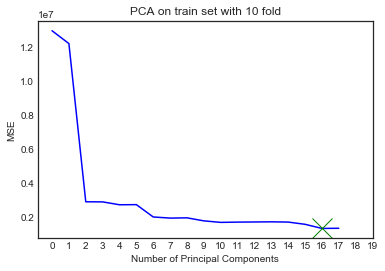

In [78]:
pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train))
print(pd.Series(np.cumsum(np.round(pca.explained_variance_ratio_*100,decimals=2))
                , index=range(1,18)))

# Setting up all parameters # 19 principal components
k_fold = KFold(n_splits=10, shuffle=True, random_state=1)
mse = [13000000]  # For a better graph
regr = skl_lm.LinearRegression()

# Loop through all components number and K-fold
for i in range(1, 18):
    mse.append(cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=k_fold, 
                                   scoring='neg_mean_squared_error').mean()*-1)


# Getting minimum MSE
min_mse_index, min_mse = min(enumerate(mse), key=itemgetter(1))

# Plot MSE
plt.plot(mse, color='b')
plt.plot(min_mse_index, min_mse, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,20))
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCA on train set with 10 fold')

In [79]:
# transform test set
X_reduced_test = pca.transform(scale(X_test))

# Run PCR on test set with M = 16
y_pred = regr.fit(X_reduced_train[:,:17], y_train).predict(X_reduced_test[:,:17])

# Save to RMSE
RMSE['PCR'] = np.sqrt(mean_squared_error(y_test, y_pred))

# Print result
print(f'Test RMSE with 16 PC: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Test RMSE with 16 PC: 1469.2426424191476


#### (f) PLS

Some notes: 
1. Don't forget to scale data
2. fit_transform train set but only transform test set

Text(0, 0.5, 'MSE')

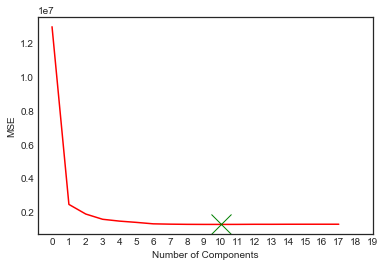

In [80]:
# Running PLS with 10 fold
k_fold = KFold(n_splits=10, random_state=1, shuffle=True)
mse = [13000000]
for i in range(1, 18):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=k_fold,
                               scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Find min mse
min_mse_index, min_mse = min(enumerate(mse), key=itemgetter(1))

# plot MSE  vs directions/components
plt.plot(mse, color='r', label='MSE')
plt.plot(min_mse_index, min_mse, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,20))
plt.xlabel('Number of Components')
plt.ylabel('MSE')    

In [81]:
# getting RMSE for test set with PLS. M = 8
pls = PLSRegression(n_components=8)
y_pred = pls.fit(scale(X_train), y_train).predict(scale(X_test))

# Add score to RMSE
RMSE['PLS'] = np.sqrt(mean_squared_error(y_test, y_pred))

# Print out result
print('PLS with M=8 has RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

PLS with M=8 has RMSE: 1472.5911578450145


#### (g) How is the result?

PCR and PLS come behind with the highest RMSE. OLS, Ridge and Lasso has almost identical 
RMSE and they are very good at predicting college application received. 

While there are differences in RMSE, it is not a big enough to be a concern.

In [82]:
pd.DataFrame.from_dict(RMSE, orient='index', columns=['RMSE'])










,RMSE
OLS,1193.756921
Ridge,1194.779677
Lasso,1193.757335
PCR,1469.242642
PLS,1472.591158
